# PyTorch Workflow


Outline:
1. Data (Preparing and Loading).
2. Build Model.
3. Fitting the Model (Training).
4. Making Predictions and Evaluating a Model (Inference).
5. Putting it all Together.

In [1]:
import torch
from torch import nn # nn contains all of PyTorch builiding blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

torch.__version__ #checking pytorch version

'2.4.0+cpu'

# 1. Data (Preparing and Loading)

Machine learning is a game of 2 parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some **known** data using the Linear Regression formula.

We'll use a Linear Regression formula to make a straight line with known **parameters**.

In [2]:
# create known parameters
weight = 0.7
bias = 0.3

# create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)

(50, 50)

## Splitting Data into Training and Test Sets
Let's create a training and test set with our data

In [4]:
# create a train/test split
train_split = int(0.8 * len(X)) # 80% of the data
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize = (10,7))
    # plot training data in blue
    plt.scatter(X_train, y_train, c='b', label='Training Data')
    # plot test data in green
    plt.scatter(X_test, y_test, c='g', label='Testing Data')

    # are there predictions?
    if predictions is not None:
        # plot the predictions if they exist
        plt.scatter(test_data, predictions, c='r', label='Predictions')

    # show the legend
    plt.legend(prop={'size':14})
    plt.show()

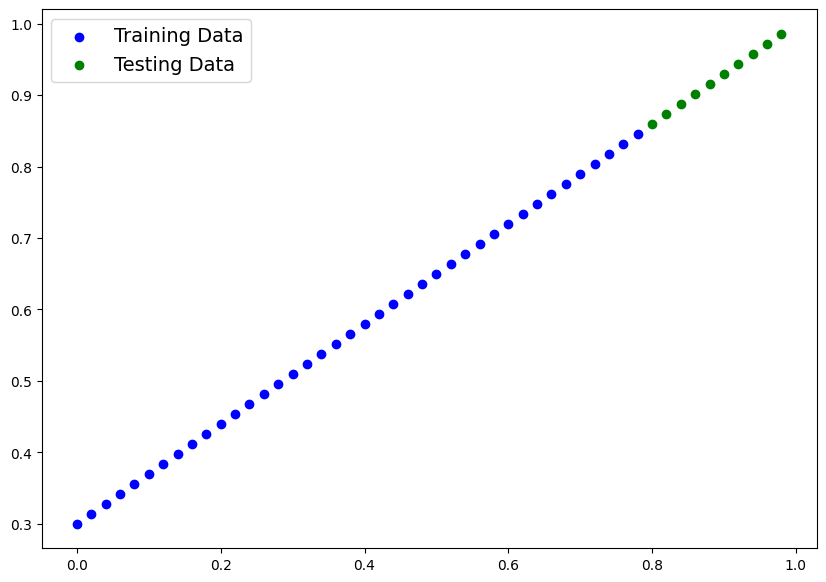

In [6]:
plot_predictions()

# 2. Build Model
What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust values to better represent (or get closer to) the ideal values (the weight & bias values used to create data)

How does is it do so?<br>
Through two main algorithms:
1. Gradient descent.
2. Backpropagation.

In [7]:
# creating linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1,
                                                requires_grad = True,
                                            dtype = torch.float))

        self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad = True,
                                         dtype = torch.float))

    # forward method to define computation in model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
        return self.weight * x + self.bias

## PyTorch model building essentials
* `torch.nn` - contains all the building blocks for computational graphs.
* `torch.nn.Parameter` - what parameters should our model try and learn, often a PyTorch layer from `torch.nn` will set these for us.
* `torch.nn.Module` - the base class for all neural network modules, if you subclass it, you should overwrite forward().
* `torch.optim` - this is where the optimizers in PyTorch live, they will help with gradient descent.
* `def forward()` - all nn.Module subclasses require you to overwrite forward. This method defines what happens in the forward computation.

## Checking the contents of our PyTorch model
We can check our model parameters or what's inside our model using `.parameters()`

In [8]:
# create a random seed
torch.manual_seed(42)

# create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# check out the parameters
list(model_0.parameters())

# list of named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making predictions using `torch.inference_mode()`
To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pased data through our model, it's going to run it through the forward() method.

In [9]:
# making predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

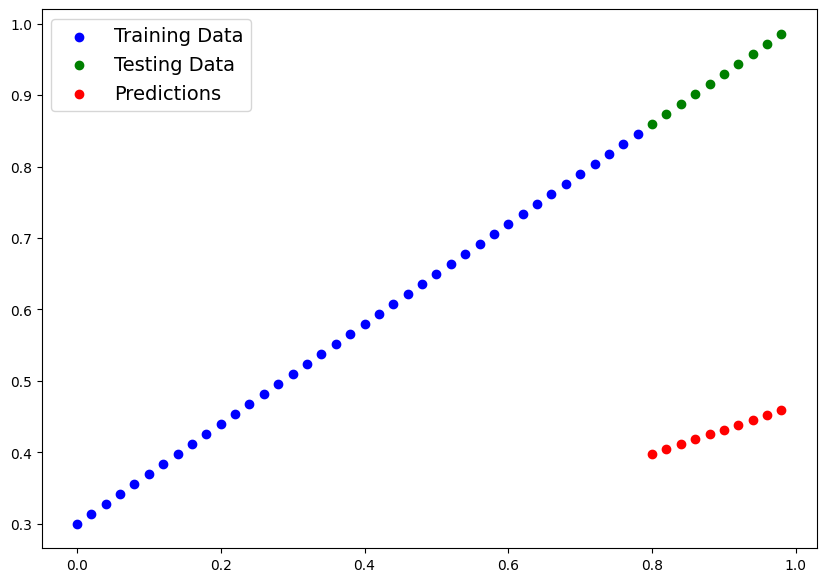

In [10]:
plot_predictions(predictions = y_preds)

# 3. Train Model
The whle idea of trasining is for our model to move from some *unknown* parameters (these may be random) to some *known* parameters or in otherwords, from a poor representation of the data to a better representation of the data.

One way to measure how por or how wrong a model's predictions are is to use loss function.

**Note**: Loss function may also be called cost function or criterion in different areas.

Things we need to start:

* **Loss Function**: A function to measure how wrong your model's predictions are to the ideal outputs (lower is better).
* **Optimizer**: Takes into account the loss of a model
  and adjusts the model's parameters (e.g. weight & bias) to improve the loss function.

Specifically for Pytorch, we need:
* A training loop, and
* A testing loop

In [11]:
# checking for parameters in model_0
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [12]:
# to get labeled parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [13]:
# setting up a loss function
loss_fn = nn.L1Loss()

# setting up an optimizer
optimizier = torch.optim.SGD(params = model_0.parameters(),
                      lr = 0.01) # lr = learning rate(hyper parameter)

## Builiding a trainig loop (and a testing loop) in PyTorch.
A couple of things we need in a training loop:

0. Loop through the data.
1. Forward pass (this invloves data moving through outr model's `forward()`) function(s) -  also called forward propagtion.
2. Calculate the loss (compare the foraward pass preds to ground truth labels)
3. Optimizier zero grad.
4. Loss backward - move backwards throught the network to calculate the gradients of each of the parameters of our model with respect to the loss (**back-propagation**).
5. Optimizer step - use the optimizer ro adjust our model's parameters to try and improve the lose (**gradient descent**).

In [14]:
torch.manual_seed(42)

# An epoch is one loop throught the data ( a hyperparameter because we set it ourselves)
epochs = 200

# tracking experiments (different values)
epoch_count = []
loss_values = []
test_loss_values = []

### TRAINING
# 0. Loop throught thr data
for epoch in range(epochs):

    # set the model to training mode
    model_0.train() # train mode in PyTorch sets all parameters that require gradients, to require gradients

    # 1. forward pass on training data using the forward() method inside
    y_pred = model_0(X_train)

    # 2. calculate the loss (how different the models preds are to the actual values)
    loss = loss_fn(y_pred, y_train)


    #3. optimizer zero grad zero the gradients of the optimizer, (they accumulate by default)
    optimizier.zero_grad()

    # 4. loss backward - perform back propagation on the loss wrt the params of the model
    loss.backward()

    # 5. optimizer step - perform gradient descent
    optimizier.step()

    ### TESTING
    model_0.eval() # turns off different settings not needed for evaluation/testing
    with torch.inference_mode():
        # 1. forward pass
        test_pred = model_0(X_test)

        # 2. calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

        #print out model state dict
        print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weight', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weight', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict([('weight', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
OrderedDict([('weight', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
OrderedDict([('weight', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
OrderedDict([('weight', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
OrderedDict([('weight', tensor([0.5116])), ('bias', tensor([0.3788]))])
E

In [15]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

In [16]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [17]:
weight, bias

(0.7, 0.3)

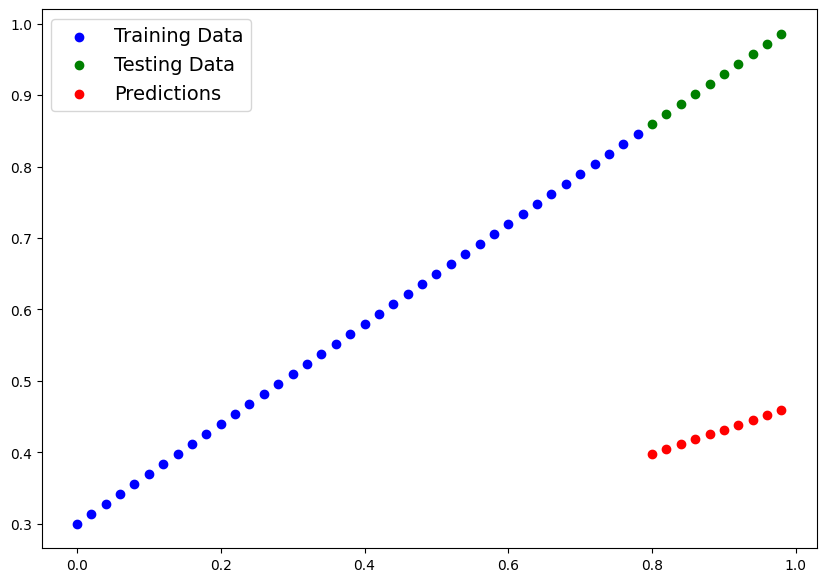

In [18]:
plot_predictions(predictions = y_preds)

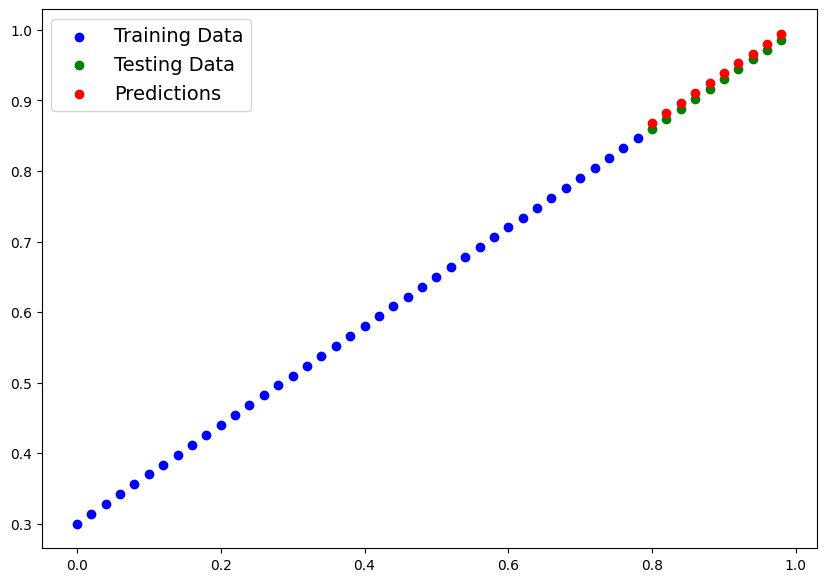

In [19]:
plot_predictions(predictions = y_preds_new)

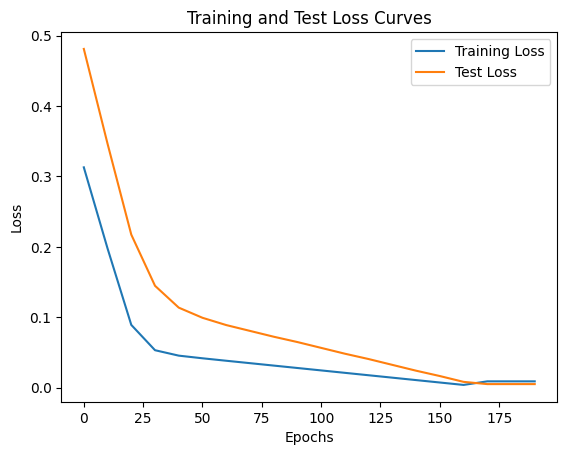

In [20]:
# plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label = 'Training Loss')
plt.plot(epoch_count, test_loss_values, label = 'Test Loss')
plt.title('Training and Test Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();

#4. Saving a model in PyTorch

There are 3 main methods you shoukd know about for saving and loading models in PyTorch.

1. `torch.save` - allows you save a PyTorch object in Python's pickle format.
2. `torch.load` - allows you load a saved PyTorch object.
3. `torch.nn.Module.load_state_dict()` - allows you to load amodel's saved state dictionary.

In [21]:
# saving PyTorch model
from pathlib import Path

# 1. create model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. save the state dict
torch.save(obj = model_0.state_dict(),
           f = MODEL_SAVE_PATH)

In [22]:
!ls -1 models

01_pytorch_workflow_model_0.pth


# 5. Loading a model in PyTorch
Since we saved our model's `state dict()` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [23]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [24]:
## to load in a state_dict(), we have to instantiate a new instace of our model class
loaded_model_0 = LinearRegressionModel()

# load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

/tmp/ipykernel_17/1974079496.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))


<All keys matched successfully>

In [25]:
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [26]:
# make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [27]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [28]:
# compare loaded_model_preds to original preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6. Putting it all together
Let's go back through the steps above and put them all together.

In [29]:
# importing libraries
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

# check PyTorch version
torch.__version__

'2.4.0+cpu'

Create device-agnostic code.<br>
This means if we have access to a GPU, our code will use it(for potentially faster computing).<br>
If no GPU is availale, the code will default to using CPU.

In [30]:
# setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


## 6.1 Data

In [31]:
# create known parameters
weight = 0.7
bias = 0.3

# create data
start = 0
end = 1
step = 0.02

# create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim= 1) # without unsqueeze, errors will pop up
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [32]:
# SPLIT DATA
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

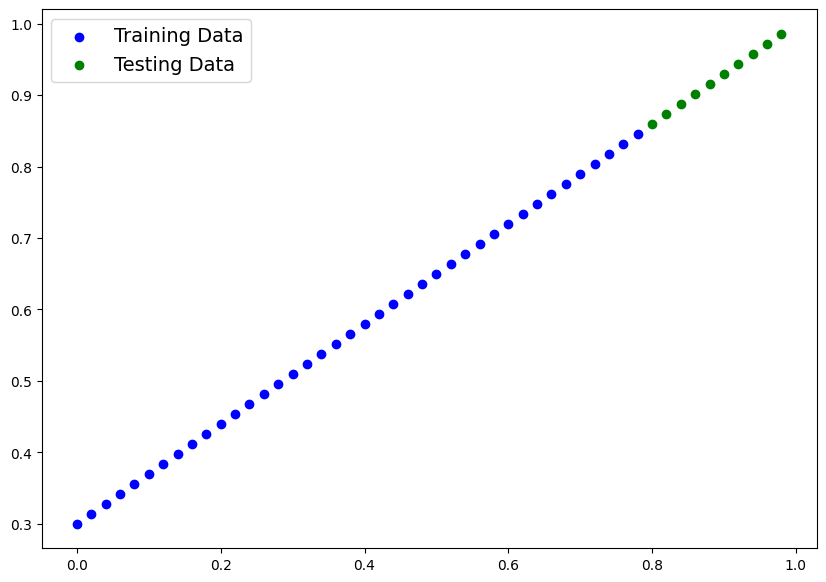

In [33]:
# plot the data

# defining plot_preds fn
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize = (10,7))
    # plot training data in blue
    plt.scatter(X_train, y_train, c='b', label='Training Data')
    # plot test data in green
    plt.scatter(X_test, y_test, c='g', label='Testing Data')

    # are there predictions?
    if predictions is not None:
        # plot the predictions if they exist
        plt.scatter(test_data, predictions, c='r', label='Predictions')

    # show the legend
    plt.legend(prop={'size':14})

    plt.show()

# using plot_preds
plot_predictions(X_train, y_train, X_test, y_test)

## 6.2 Build Model

In [34]:
# create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # using nn.Linear() to create model params
        self.linear_layer = nn.Linear(in_features = 1,
                                  out_features = 1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [35]:
# set model to use target device
next(model_1.parameters()).device

device(type='cpu')

In [36]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

## 6.3 Training Model
For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [37]:
# setting up loss fn
loss_fn = nn.L1Loss()

# setting up optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                        lr = 0.01)

In [38]:
# training loop
torch.manual_seed(42)

epochs = 200

# putting data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform back propagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### TESTING
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}')

Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch: 10 | Loss: 0.4399680495262146 | Test Loss: 0.4392663538455963
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954827964305878 | Test Loss: 0.16984674334526062
Epoch: 40 | Loss: 0.09433844685554504 | Test Loss: 0.03513689711689949
Epoch: 50 | Loss: 0.023886386305093765 | Test Loss: 0.04784906655550003
Epoch: 60 | Loss: 0.0199567973613739 | Test Loss: 0.04580312222242355
Epoch: 70 | Loss: 0.016517987474799156 | Test Loss: 0.0375305712223053
Epoch: 80 | Loss: 0.013089170679450035 | Test Loss: 0.029944902285933495
Epoch: 90 | Loss: 0.009653178043663502 | Test Loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215679459273815 | Test Loss: 0.014086711220443249
Epoch: 110 | Loss: 0.002787243574857712 | Test Loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test Loss: 0.013801807537674904
Epoch: 130 | Loss: 0.0012645035749301314 | Test Loss: 0.01380180753767

In [39]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [40]:
weight, bias

(0.7, 0.3)

In [41]:
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

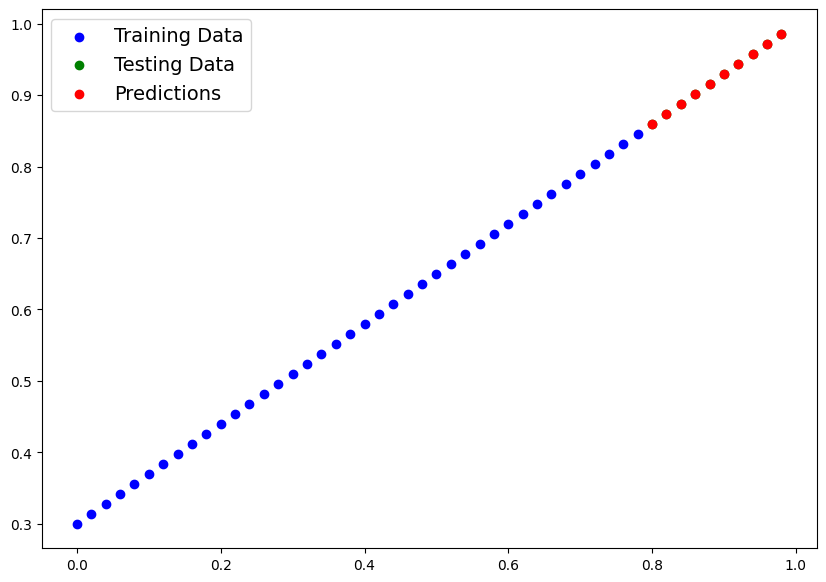

In [42]:
y_preds = y_preds.cpu()
plot_predictions(predictions = y_preds.cpu())

In [43]:
from pathlib import Path

MODEL_NAME = '01_pytorch_workflow_model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj = model_1.state_dict(),
           f = MODEL_SAVE_PATH)

In [44]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [45]:
# loading the model
# create new instance of linear regression model v2
loaded_model_1 = LinearRegressionModelV2()

# load the saved state_dict of model_1 (this will update the new instance with updated parameters)
loaded_model_1.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

loaded_model_1.to(device)

/tmp/ipykernel_17/1887818031.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(f = MODEL_SAVE_PATH))


LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [46]:
next(loaded_model_1.parameters()).device

# evaluate model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])